In [3]:
import scipy
from sentence_transformers import SentenceTransformer, util

model_try = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
config_sentence_transformers.json: 100%|██████████| 122/122 [00:00<00:00, 237kB/s]
README.md: 100%|██████████| 4.09k/4.09k [00:00<00:00, 8.67MB/s]
sentence_bert_config.json: 100%|██████████| 53.0/53.0 [00:00<00:00, 117kB/s]
config.json: 100%|██████████| 645/645 [00:00<00:00, 1.19MB/s]
pytorch_model.bin: 100%|██████████| 471M/471M [00:05<00:00, 90.1MB/s] 
tokenizer_config.json: 100%|██████████| 480/480 [00:00<00:00, 1.09MB/s]
tokenizer.json: 100%|██████████| 9.08M/9.08M [00:00<00:00, 106MB/s]
1_Pooling/config.json: 100%|██████████| 190/190 [00:00<00:00, 448kB/s]


In [4]:
emoji_list = ["💥",'🚨','🤏','🚀','🤑','🤔','❤️','💰','⚠️','🥳','✅','🔥','🏆','🎁','😂']
simi = []
for item in emoji_list:
    encode1 = model_try.encode(item)
    encode2 = model_try.encode("this is financially positive")
    simi.append(util.pytorch_cos_sim(encode1,encode2))

In [5]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

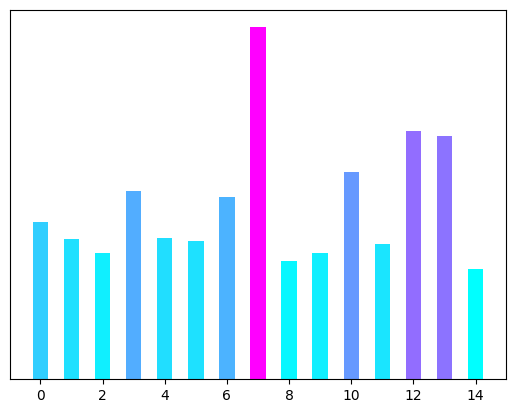

In [6]:
#plt.ylim(0.30,0.4)
plt.yticks([],[])
norm = plt.Normalize(min([float(item[0]) for item in simi]), max([float(item[0]) for item in simi]))
colors = cm.cool(norm([float(item[0]) for item in simi]))
plt.bar(np.arange(len(simi)),[float(item[0]) for item in simi],width = 0.5,color=colors)
plt.savefig("emoji_onlybert.png",transparent = True)

In [7]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW
import random
import pandas as pd

# 1. 加载预训练的 BERT 模型和分词器
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

loss_history = []
# 冻结 BERT 层的参数
for param in bert_model.parameters():
    param.requires_grad = False

# 2. 定义微调模型
class BertFineTuningModel(torch.nn.Module):
    def __init__(self, bert_model):
        super().__init__()
        self.bert = bert_model
        # 添加额外的 Transformer 层
        self.transformer_layer = torch.nn.TransformerEncoderLayer(d_model=768, nhead=8)

    def forward(self, input_ids, attention_mask, token_index):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state
        transformed = self.transformer_layer(last_hidden_state)
        token_embeddings = transformed[torch.arange(input_ids.size(0)), token_index]
        return token_embeddings

# 3. 示例数据集
class MyDataset(Dataset):
    def __init__(self, sentences, tokenizer, max_length=128):
        self.sentences = sentences
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        
        #line one
        inputs = self.tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=self.max_length, padding='max_length', truncation=True, return_tensors='pt')
        

        input_ids = inputs['input_ids'][0]
        
        #line two
        attention_mask = inputs['attention_mask'][0]
        

        # 随机选择一个 token 的位置
        token_index = random.randint(0, len(input_ids) - 1)
        return input_ids, attention_mask, token_index

# 4. 训练设置
model = BertFineTuningModel(bert_model)


In [8]:
model.load_state_dict(torch.load('bert_fine_tuned_with_transformer_layer.pth'))

<All keys matched successfully>

In [9]:
import torch
from transformers import BertTokenizer

# 加载模型
model = BertFineTuningModel(bert_model)
model.load_state_dict(torch.load('bert_fine_tuned_with_transformer_layer.pth'))
model.eval()

# 准备数据
def prepare_data(text, tokenizer, max_length=128):
    inputs = tokenizer.encode_plus(text, add_special_tokens=True, max_length=max_length, 
                                   padding='max_length', truncation=True, return_tensors='pt')
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']
    return input_ids, attention_mask

# 示例文本
text = "💰The return of the BSC king To the moom🚀"
word_to_embed = "🚀"  # 您想嵌入的词

# 数据准备
input_ids, attention_mask = prepare_data(text, tokenizer)

# 找到感兴趣的词的索引
token_index = tokenizer.encode(text, add_special_tokens=True).index(tokenizer.encode(word_to_embed, add_special_tokens=False)[0])

# 获取嵌入
with torch.no_grad():
    embeddings = model(input_ids, attention_mask, torch.tensor([token_index]))

print(embeddings)


tensor([[ 2.7387e-01,  1.1745e-01,  6.1859e-01, -7.4332e-01,  1.9857e-01,
         -3.6864e-01,  6.3683e-01, -2.1701e-01, -2.1357e-01, -5.6166e-01,
         -5.9399e-01, -3.9202e-01,  3.8441e-02, -2.1293e-01,  1.0210e+00,
          6.0932e-01,  4.4334e-01, -9.7643e-02, -8.0080e-02,  1.1106e+00,
          5.8801e-01,  1.8522e-01, -2.0836e-01, -2.0450e-01,  4.5286e-01,
          3.6371e-01,  6.2951e-02, -2.2970e-01, -8.3452e-01,  2.4473e-01,
          6.1205e-01, -7.9709e-01, -8.9441e-02,  1.6280e-01,  9.6227e-02,
          9.0434e-02,  9.0230e-02, -9.9629e-02, -2.2374e-02,  3.2503e-01,
          2.8020e-01, -8.4355e-01,  1.3821e-01, -5.9134e-02, -5.4867e-01,
         -7.2324e-01, -2.0977e-01, -4.3410e-01,  5.1260e-01, -9.5113e-01,
         -5.5498e-01,  1.2605e-01,  3.8785e-01,  3.0568e-01,  3.1204e-02,
          5.0501e-01,  5.5546e-01, -5.9224e-01, -1.4493e-01, -6.5330e-01,
          1.5603e-01, -1.3660e-01, -3.8904e-01, -1.4874e-01, -2.1990e-01,
          1.0724e-01,  4.9514e-01,  4.

In [10]:

# 示例文本
text = "It's positive and optimistic and promising and lively in market!"
word_to_embed = "positive"  # 您想嵌入的词

# 数据准备
input_ids, attention_mask = prepare_data(text, tokenizer)

# 找到感兴趣的词的索引
token_index = tokenizer.encode(text, add_special_tokens=True).index(tokenizer.encode(word_to_embed, add_special_tokens=False)[0])

# 获取嵌入
with torch.no_grad():
    embeddings_p = model(input_ids, attention_mask, torch.tensor([token_index]))

print(embeddings_p)

tensor([[-1.9007e-01, -3.6754e-01,  2.6513e-01, -7.0126e-02,  2.7683e-01,
         -1.8420e-01,  3.6976e-02,  7.4770e-01, -5.1322e-01, -1.5176e-01,
         -1.9215e-01, -6.3047e-01,  2.4062e-01,  2.3594e-01,  5.8710e-01,
          2.2614e-01,  6.6088e-01, -2.3779e-01,  9.4288e-01, -2.2287e-01,
         -7.5146e-01, -5.5156e-01, -4.0767e-01,  7.5963e-01,  4.5112e-01,
         -2.1670e-01,  7.3977e-01, -1.2398e-01, -3.9872e-01, -7.7095e-01,
          1.1238e+00,  5.5694e-01, -1.6633e-03,  4.9054e-01, -2.1841e-01,
         -9.4923e-01, -8.4614e-01,  3.5900e-01, -3.0861e-01,  4.4395e-01,
         -4.1040e-01, -1.0889e+00, -1.2256e-01,  2.2858e-01,  3.4886e-01,
         -6.4717e-01, -3.2200e-01,  4.6144e-01,  9.6083e-01, -7.7850e-01,
         -3.1813e-02,  2.9753e-01, -9.5278e-01,  1.1164e-01, -1.2119e-01,
          6.6692e-01, -1.5941e-01, -1.9257e-01, -4.6136e-01, -3.0148e-01,
          1.3370e-01, -5.4084e-01,  3.9723e-01, -2.4354e-01,  8.1656e-02,
          2.5045e-02, -1.2048e-04,  5.

In [12]:
import torch
import torch.nn.functional as F

In [13]:
texts =["When the bear strikes, we strike back!💥[blust]",'🚨 🚨 🚨[warning]  69,995,990 #USDT (69,939,993 USD) transferred from #Kraken to #Bitfinex','Dont invest at all 🤏','Meet experts from @0xPolygonLabs@maplefinance@PropyInc@blockchain @QuickNode and more to come 🚀[rocket fly to the sky]','🤑[lots money]SupraOracles Airdrop: Earn Up to $500k SUPRA Tokens | Join Now!','Wonder if we reach 500 ETH by the end of the epoch! 🤔','The last few days have provided us with a lot of negative bad news in crypto ❤️[broken heart]','💰[money bag]The return of the BSC king To the moom🚀','⚠️The TUSD stablecoin, whose largest coiner is Justin Sun and then joined by Binance, today lost its peg to $1 (for now)','🥳[highly happy celebrating face] Massive - Now that Argentina has a pro #Bitcoin president, there’s a strong likelihood they adopt #BTC as legal tender. LFG 🇦🇷 https://t.co/0FWW7lgzds29,2023-11-19 23:24:02+00:00,$RBT Degens A Big Congratulations 👏','✅[right!] Higher Earn Plus bonuses, up to 10% p.a.',"🔥 Gorilla Defi's revolutionary presale concept goes live on 23rd Jan.With APY 328%.",'Winner 🏆 : @holaeskarepPlease DM with this link to Claim Your Prize 🎁','Winner 🏆 : @holaeskarepPlease DM with this link to Claim Your Prize 🎁','it looks like when you pass laws with no law in place you can not follow the law 😂']
words = ["💥",'🚨','🤏','🚀','🤑','🤔','❤️','💰','⚠️','🥳','✅','🔥','🏆','🎁','😂']
name = ['blask','warning light','tiny','rocket','money face','thinking face','broken heart','money bag','warning triangle','celebrating face','check sigh','fire','champign cup','gift','laugh cry']
embeddings_words = []
similarity = []
for i in range(len(texts)):
    
    # 示例文本
    text = texts[i]
    word_to_embed = words[i]  # 您想嵌入的词

    # 数据准备
    input_ids, attention_mask = prepare_data(text, tokenizer)

    # 找到感兴趣的词的索引
    token_index = tokenizer.encode(text, add_special_tokens=True).index(tokenizer.encode(word_to_embed, add_special_tokens=False)[0])

    # 获取嵌入
    with torch.no_grad():
        embeddings = model(input_ids, attention_mask, torch.tensor([token_index]))
    cosine_similarity = F.cosine_similarity(embeddings, embeddings_p)
    similarity.append(cosine_similarity)
    embeddings_words.append(embeddings[0])
    

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

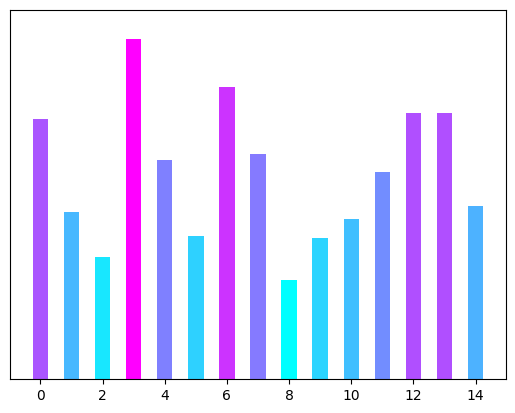

In [15]:
plt.ylim(0.25,0.45)
norm = plt.Normalize(min([float(item[0]) for item in similarity]), max([float(item[0]) for item in similarity]))
colors = cm.cool(norm([float(item[0]) for item in similarity]))
plt.bar(np.arange(len(similarity)),[float(item[0]) for item in similarity],width = 0.5,color=colors)
plt.yticks([],[])
plt.savefig("example.png",transparent = True)